In [ ]:
# from sklearn.manifold import MDS
# import pandas as pd

# # data = load.readPd('dataset/gauss_data.txt')
# dis = load.disM_line('dataset/example_distances.txt')
# mds = MDS(n_components=2, dissimilarity='precomputed')
# data = mds.fit_transform(dis)
# data = pd.DataFrame(data, columns=['x', 'y'])


In [1]:
from load import *

load = load_xy('dataset/xy/')


600
[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]
          x       y  clusterID
215   7.704   8.672          6
388  13.708  15.048         10
456   4.614  12.526         12
139   9.916  12.028          4
93   11.106  11.868          3


<AxesSubplot:xlabel='x', ylabel='y'>

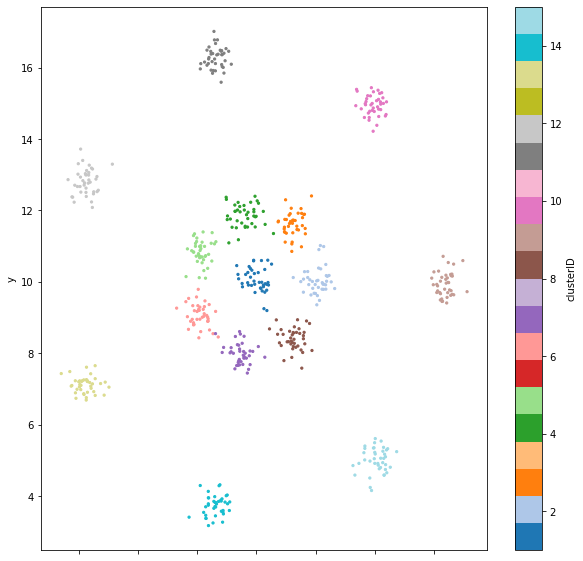

In [8]:
data = next(load)
print(len(data))
print(data['clusterID'].unique())
print(data.sample(5))
data.plot.scatter(x='x', y='y', c='clusterID', colormap='tab20', s=5, figsize=(10, 10))


dc: 0.2488051446413441
178
[178 496 428 548 451 366 359 279 587  97 299  74   6 203 154]


[Text(0.5, 1.0, 'decision graph'),
 Text(0.5, 0, '$\\rho$'),
 Text(0, 0.5, '$\\delta$')]

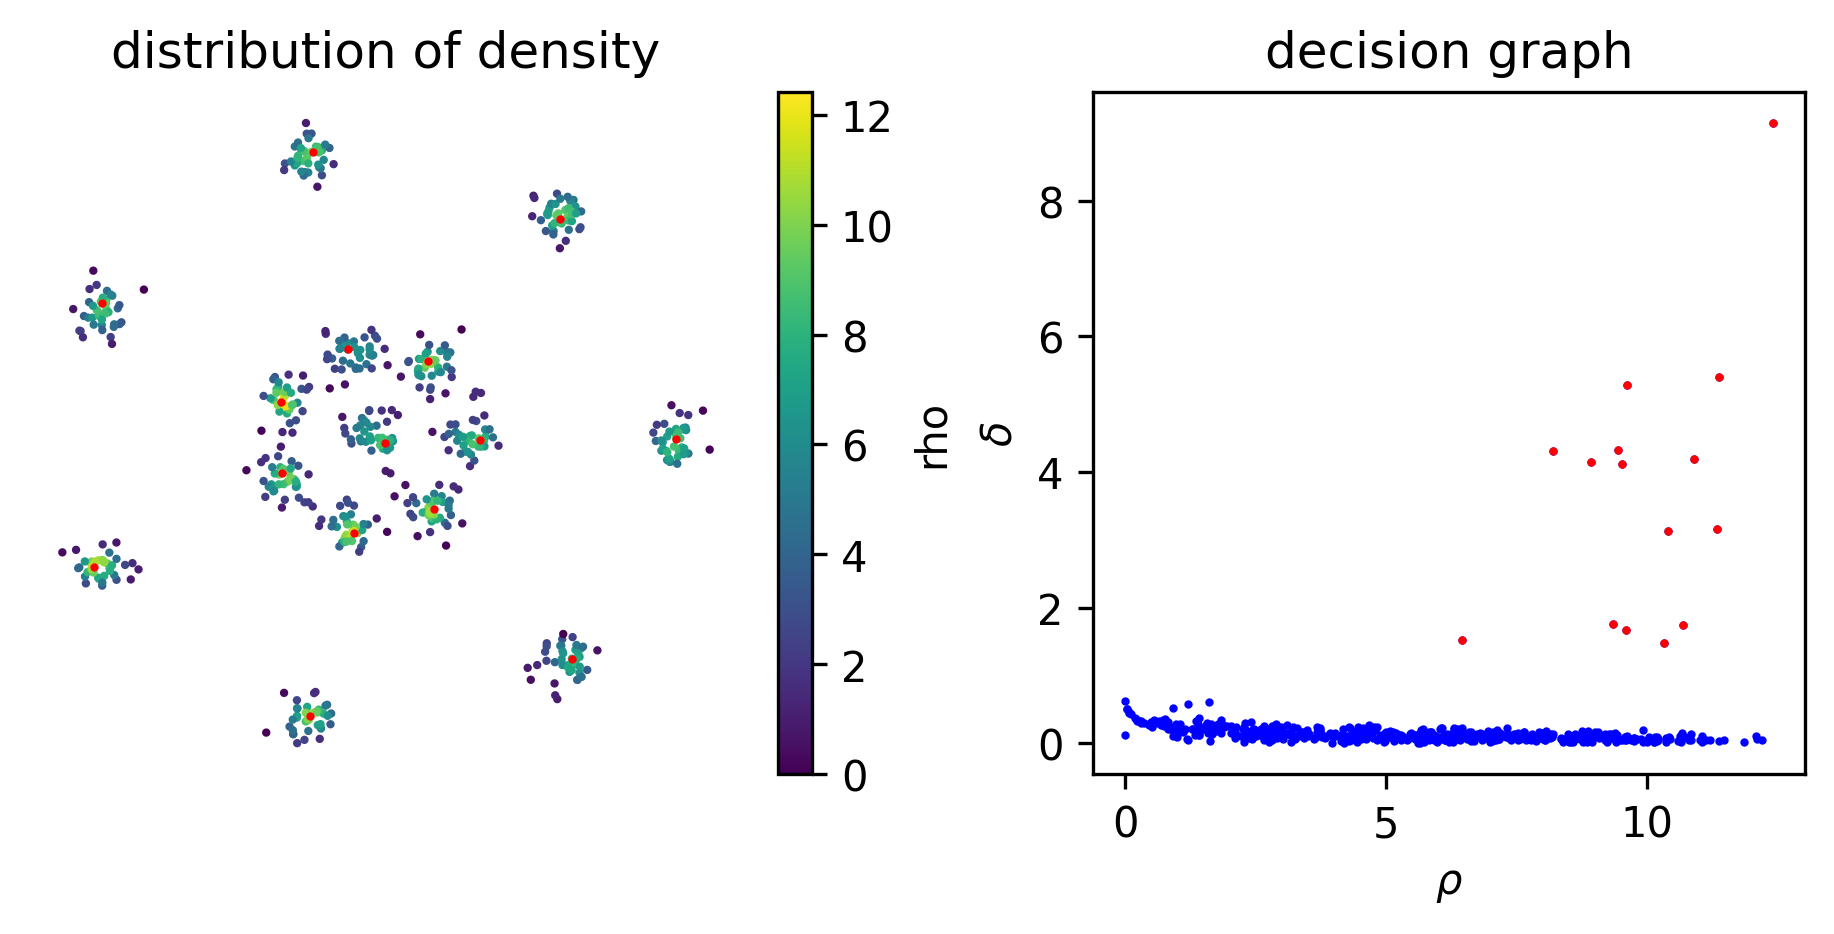

In [10]:
from DPC import DPC

dpc = DPC(data[['x', 'y']])
dpc.calDis()
dpc.calDc_raw(0.01)
dpc.calRho()
dpc.calDel()
dpc.calGam()

dpc.getCen(15)


import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 2, figsize=(6, 3), dpi=300, constrained_layout=True)
dpc.df.plot.scatter(x="x", y='y', c='rho', cmap='viridis', s=1, ax=ax[0])
dpc.df.plot.scatter(x="rho", y='delta', c='blue', s=1, ax=ax[1])

for i in dpc.centers:
    ax[0].scatter(dpc.df.loc[i, 'x'], dpc.df.loc[i, 'y'], c='red',s=1)
    ax[1].scatter(dpc.df.loc[i, 'rho'], dpc.df.loc[i, 'delta'], c='red',s=1)

# i = 2336
# ax[0].scatter(data.loc[i, 'x'], data.loc[i, 'y'], c='r', s=2)

ax[0].set_axis_off()
ax[0].set(title='distribution of density')
ax[1].set(title='decision graph', xlabel=r'$\rho$', ylabel=r'$\delta$')


<AxesSubplot:ylabel='Frequency'>

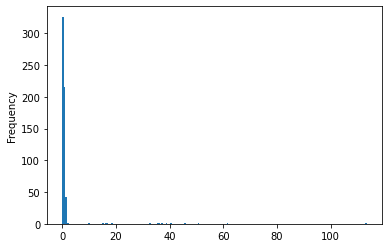

In [11]:
dpc.df['gamma'].plot.hist(bins=200)

In [12]:
import matplotlib.pyplot as plt
dpc.cluster()

print(np.sort(dpc.df['clusterID'].unique()))



0 178
1 496
2 428
3 548
548
535
538
521
544
553
531
532
556
546
558
540
543
559
520
523
536
547
522
550
539
528
525
549
551
524
557
530
545
552
534
537
555
541
527
526
542
533
554
529
4 451
5 366
6 359
7 279
8 587
9 97
10 299
11 74
12 6
13 203
14 154
[ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15.]


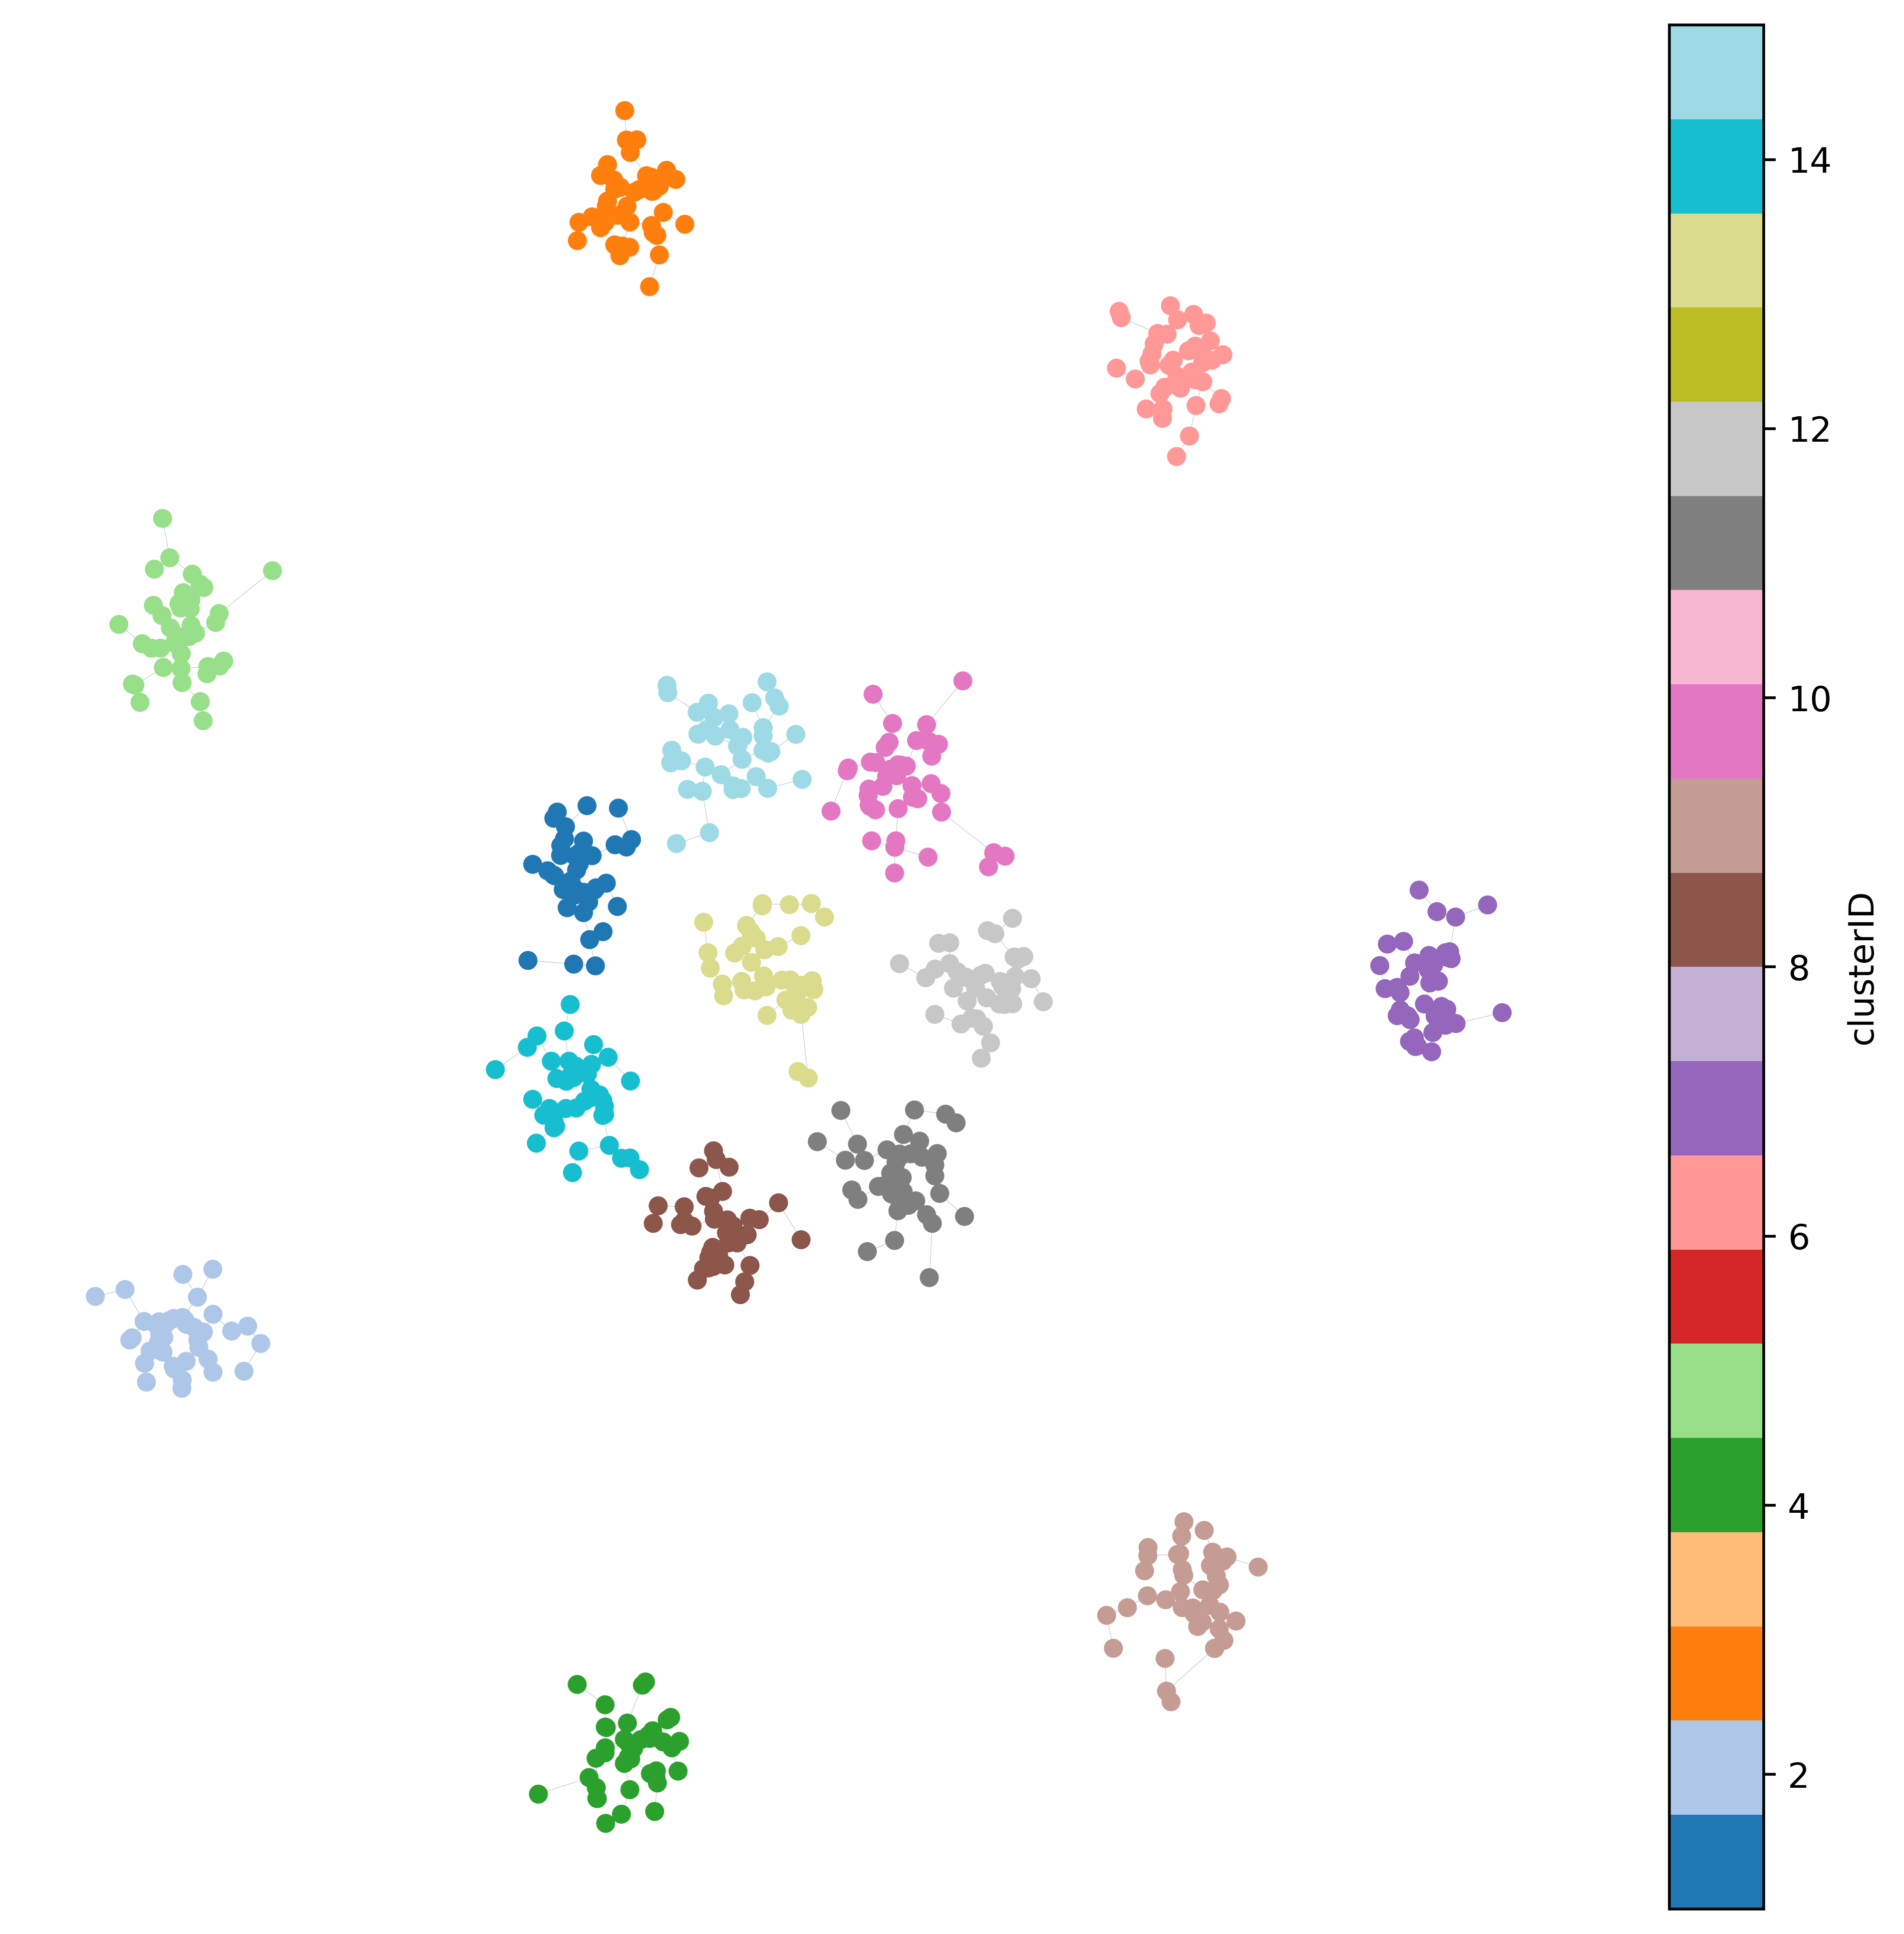

In [13]:

fig, ax = plt.subplots(figsize=(10, 10), dpi=500)
for i, ri in dpc.df.drop(dpc.centers).iterrows():
    ax.arrow(ri['x'], ri['y'], dpc.df.loc[ri['toh'], 'x']-ri['x'], dpc.df.loc[ri['toh'], 'y']-ri['y'], lw=0.01, head_width=0.02)
# dpc.df.plot.scatter(x="x", y='y', s=1, c='rho', cmap='viridis', ax=ax)
# for i in [dpc.centers[7]]:
#     ax.scatter(dpc.df.loc[i,'x'],dpc.df.loc[i,'y'],c='r')

dpc.df.plot.scatter(x='x', y='y', c='clusterID', cmap='tab20', ax=ax)
ax.set_axis_off()
